In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import cvxpy
import scipy
import scs
import superscs
from wurlitzer import pipes

In [2]:
print(scs.__version__)
assert(int(scs.__version__[0]) >= 2)

2.0.2


In [3]:
probs = []

In [4]:
# Random LP
np.random.seed(hash('lp') % 2 ** 31)

# Dimensions
n = 100
m = 70

A = scipy.sparse.random(m, n, density=0.2, data_rvs = np.random.randn)
b = np.random.randn(m, 1)
c = np.random.rand(n, 1)

# Problem construction
x = cvxpy.Variable(n)
objective = cvxpy.Minimize(c.T * x)
constraints = [x >= 0, A * x <= b]
probs.append(cvxpy.Problem(objective, constraints))

In [5]:
# Optimal control
np.random.seed(hash('opt-control') % 2 ** 31)

# Problem data
T = 10
n, p = (10, 5)
A = np.random.randn(n, n)
B = np.random.randn(n, p)
x_init = np.random.randn(n, 1)
x_final = np.random.randn(n, 1)

def step(A, B, x_prev):
    x = cvxpy.Variable(n, 1)
    u = cvxpy.Variable(p, 1)
    cost = sum(cvxpy.square(u)) + sum(cvxpy.abs(x))
    constraint = (x == A * x_prev + B * u)
    return cost, constraint, x

x = cvxpy.Variable(n, 1)
constraints = [(x == x_init)]
total_cost = 0.
for t in range(T):
    cost_t, constraint_t, x = step(A, B, x)
    constraints.append(constraint_t)
    total_cost += cost_t

constraints.append(x == x_final)
probs.append(cvxpy.Problem(cvxpy.Minimize(total_cost), constraints))

In [6]:
# Lasso
np.random.seed(hash('lasso') % 2 ** 31)

# Dimensions
n = 100
m = 50

x_true = scipy.sparse.rand(n, 1, density=0.1) 
A = scipy.sparse.random(m, n, density=0.2, data_rvs = np.random.randn)
b = A * x_true + 0.1 * np.random.randn(m, 1)
mu = 1

# Problem construction
x = cvxpy.Variable(n)
objective = cvxpy.Minimize(0.5 * cvxpy.sum_squares(A*x - b) + mu * cvxpy.norm1(x))
probs.append(cvxpy.Problem(objective))

In [7]:
# Nonnegative Lasso
np.random.seed(hash('nonneg-lasso') % 2 ** 31)

# Dimensions
n = 100
m = 50

x_true = scipy.sparse.rand(n, 1, density=0.1) 
A = scipy.sparse.random(m, n, density=0.2, data_rvs = np.random.randn)
b = A * x_true + 0.1 * np.random.randn(m, 1)
mu = 1

# Problem construction
x = cvxpy.Variable(n)
objective = cvxpy.Minimize(0.5 * cvxpy.sum_squares(A*x - b) + mu * cvxpy.norm1(x))
constraints = [x >= 0]
probs.append(cvxpy.Problem(objective, constraints))

In [8]:
# SDP for closest elemwise-positive PSD matrix in some metric
np.random.seed(hash('sdp') % 2 ** 31)

# create data P
n = 50
P = np.random.randn(n, n)
P = P + P.T
Z = cvxpy.semidefinite(n)

objective = cvxpy.Maximize(cvxpy.lambda_min(P - Z))
probs.append(cvxpy.Problem(objective, [Z >= 0]))

In [9]:
# Basis pursuit
np.random.seed(hash('basis-pursuit') % 2 ** 31)

n = 300
m = 100
x = cvxpy.Variable(n)
A = np.random.rand(m, n)
x0 = scipy.sparse.rand(n, 1, 0.1)
b = A*x0

probs.append(cvxpy.Problem(cvxpy.Minimize(cvxpy.norm1(x)), [A*x == b]))

In [10]:
# Chebyshev
np.random.seed(hash('chebyshev') % 2 ** 31)

def normalized_data_matrix(m, n):
    A = np.random.randn(m, n)
    A /= np.sqrt(np.sum(A**2, 0))
    return A

m = 100
n = 200
k = 50
A = [normalized_data_matrix(m, n) for i in range(k)]
B = normalized_data_matrix(k, n)
c = np.random.rand(k)

x = cvxpy.Variable(n)
t = cvxpy.Variable(k)

f = cvxpy.max_entries(t + cvxpy.abs(B * x - c))
constraints = []
for i in range(k):
    constraints.append(cvxpy.norm(A[i]*x) <= t[i])

probs.append(cvxpy.Problem(cvxpy.Minimize(f), constraints))

In [11]:
# Least absolute deviation
np.random.seed(hash('least-abs-dev') % 2 ** 31)

m = 5000
n = 200

A = np.random.randn(m,n);
b = A.dot(np.random.randn(n))

# Add outlier noise.
k = int(0.02 * m)
idx = np.random.randint(m, size=k)
b[idx] += 10 * np.random.randn(k)

x = cvxpy.Variable(n)

probs.append(cvxpy.Problem(cvxpy.Minimize(cvxpy.norm1(A*x - b))))

In [12]:
# P-norm
np.random.seed(hash('p-norm') % 2 ** 31)

n = 20
m = int(n / 4)

G = np.random.randn(m, n)
f = np.random.randn(m, 1)

power = np.pi
x = cvxpy.Variable(n)
constraints = [G*x == f]
probs.append(cvxpy.Problem(cvxpy.Minimize(cvxpy.norm(x, power)), constraints))

In [13]:
# L1-regularized Logistic regression
np.random.seed(hash('log-reg') % 2 ** 31)

p = 1000   # features
q = 10 * p  # total samples

w_true = np.random.randn(p, 1)
X_tmp = np.random.randn(p, q)

ips = -w_true.T.dot(X_tmp)
ps = (np.exp(ips)/(1 + np.exp(ips))).T
labels = 2*(np.random.rand(q,1) < ps) - 1

X_pos = X_tmp[:,np.where(labels==1)[0]]
X_neg = X_tmp[:,np.where(labels==-1)[0]]
X = np.hstack([X_pos, -X_neg]) # include labels with data

lam = 2
w = cvxpy.Variable(p, 1)
obj = (cvxpy.sum_entries(cvxpy.log_sum_exp(cvxpy.vstack([np.zeros((1,q)), w.T*X]), axis = 0))
        + lam * cvxpy.norm(w,1))

probs.append(cvxpy.Problem(cvxpy.Minimize(obj)))

In [14]:
# Matrix completion
np.random.seed(hash('matrix-completion') % 2 ** 31)

m = 100
n = 50

M = np.random.randn(m * n)
n_missing = int(0.8 * m * n)
missing_idx = np.random.permutation(m * n)[:n_missing]
valid_idx = np.setdiff1d(np.arange(m * n), missing_idx)

M[missing_idx] = 0.
X = cvxpy.Variable(m * n)

lam = 0.5
diff = cvxpy.reshape(X, m, n) - np.reshape(M, (m, n))
obj = cvxpy.norm(diff, "nuc") + lam * cvxpy.sum_squares(X)
constraints = [X[valid_idx] == M[valid_idx]]

probs.append(cvxpy.Problem(cvxpy.Minimize(obj), constraints))

In [15]:
# Min-norm
np.random.seed(hash('min-norm') % 2 ** 31)

m = 500
n = int(m / 2)
A = np.random.randn(m, n)
b = 10 * np.random.randn(m, 1)
G = 2 * np.random.randn(2 * n, n)

x = cvxpy.Variable(n)
obj = cvxpy.norm(A * x - b)
constraints = [cvxpy.norm(G * x) <= 1]

probs.append(cvxpy.Problem(cvxpy.Minimize(obj), constraints))

In [16]:
# Lyapunov stability
np.random.seed(hash('lyapunov') % 2 ** 31)

n = 100
A = np.diag(-np.logspace(-0.5, 1, n))
U = scipy.linalg.orth(np.random.randn(n,n))
A = U.T.dot(A.dot(U))

P = cvxpy.Symmetric(n, n)
obj = cvxpy.trace(P)
constraints = [A.T*P + P*A << -np.eye(n), P >> np.eye(n)]

probs.append(cvxpy.Problem(cvxpy.Minimize(obj), constraints))

In [17]:
# Portfolio
np.random.seed(hash('portfolio') % 2 ** 31)

m = 500
n = 5000
density = 0.1

mu = np.exp(0.01 * np.random.randn(n)) - 1.  # returns
D = np.random.rand(n) / 10.  # idiosyncratic risk
F = scipy.sparse.rand(n, m, density) / 10.  # factor model

lambda_risk = 1
leverage = 1

x = cvxpy.Variable(n)
obj = mu.T * x - lambda_risk * (cvxpy.sum_squares(F.T.dot(x)) +
                              cvxpy.sum_squares(cvxpy.mul_elemwise(D, x)))

constraints = [cvxpy.sum_entries(x) == leverage, x >= 0]

probs.append(cvxpy.Problem(cvxpy.Maximize(obj), constraints))

In [18]:
# Sparse covariance estimation
np.random.seed(hash('cov-estim') % 2 ** 31)

num_samples = 10
n = 20
lam = 0.1

A = scipy.sparse.rand(n, n, 0.01)
A = A.T.dot(A).todense() + 0.1 * np.eye(n)
L = np.linalg.cholesky(np.linalg.inv(A))
X = L.dot(np.random.randn(n, num_samples)) # Draw m experiments according to the covariance matrix A^-1
S = X.dot(X.T) / num_samples # Estimate of covariance matrix
mask = np.ones((n,n)) - np.eye(n)

theta = cvxpy.Variable(n, n)

obj = (lam*cvxpy.norm1(cvxpy.mul_elemwise(mask, theta)) +
       cvxpy.trace(S * theta) - cvxpy.log_det(theta))
probs.append(cvxpy.Problem(cvxpy.Minimize(obj)))

In [19]:
# Fused Lasso
np.random.seed(hash('fused-lasso') % 2 ** 31)

m = 1000
ni = 10
k = 1000
rho=0.05
sigma=0.05

A = np.random.randn(m, ni * k)
A /= np.sqrt(np.sum(A ** 2, 0))

x0 = np.zeros(ni * k)
for i in range(k):
    if np.random.rand() < rho:
        x0[i * ni:(i + 1) * ni] = np.random.rand()

b = A.dot(x0) + sigma * np.random.randn(m)
lam = 0.1 * sigma * np.sqrt(m * np.log(ni * k))

x = cvxpy.Variable(ni * k)
obj = cvxpy.sum_squares(A * x - b) + lam * cvxpy.norm1(x) + lam * cvxpy.tv(x)
probs.append(cvxpy.Problem(cvxpy.Minimize(obj)))

In [20]:
# SVM
np.random.seed(hash('svm') % 2 ** 31)

m = 150
n = 500
A = np.random.randn(m, n)
x0 = np.random.rand(n)
y = np.sign(A.dot(x0) + 0.05*np.random.randn(m))

lam = 1.0
x = cvxpy.Variable(n)
obj = ((1./m) * cvxpy.sum_entries(cvxpy.pos(1 - cvxpy.mul_elemwise(y, A * x)))
       + lam * cvxpy.norm(x, 1))

probs.append(cvxpy.Problem(cvxpy.Minimize(obj)))

In [21]:
# Robust PCA
np.random.seed(hash('robust-pca') % 2 ** 31)

n = 100
r = 10 # Rank
density = 0.1

L0 = np.random.randn(n, r).dot(np.random.randn(r, n)) # Low rank matrix
S0 = scipy.sparse.rand(n, n, density) # Sparse matrix w/ Normally distributed entries.
S0.data = 10 * np.random.randn(len(S0.data))

M = L0 + S0

L = cvxpy.Variable(n, n)
S = cvxpy.Variable(n, n)

lam = 0.1
obj = cvxpy.norm(L, "nuc") + lam * cvxpy.norm1(S)
constraints = [L + S == M]

probs.append(cvxpy.Problem(cvxpy.Minimize(obj), constraints))

In [22]:
# Robust Gaussian covariance estimation
np.random.seed(hash('rob-cov-var') % 2 ** 31)

m = 11 # Number of observations of each random variable
n = 5 # Number of random variables
k = 3 # Needs to be less than m. 

A = np.matrix(np.random.rand(m, n))
A -= np.mean(A, axis=0)
K = np.array([(A[i].T * A[i]).flatten() for i in range(m)])

sigma_inv1 = cvxpy.Variable(n,n) # Inverse covariance matrix
t = cvxpy.Variable(m)
tdet = cvxpy.Variable(1)

obj = cvxpy.sum_largest(t+tdet, k)
z = K*cvxpy.reshape(sigma_inv1, n*n, 1)
constraints = [-cvxpy.log_det(sigma_inv1) <= tdet, t == z]
probs.append(cvxpy.Problem(cvxpy.Minimize(obj), constraints))

In [23]:
# Infinite push
np.random.seed(hash('infinite-push') % 2 ** 31)

m = 100
n = 200
d = 20
np.random.seed(0)

Xp = np.random.randn(m, d)
Xn = np.random.randn(n, d)

lam = 1
theta = cvxpy.Variable(d)
Z = cvxpy.max_elemwise(1 - (Xp * theta * np.ones((1,n)) - (Xn * theta * np.ones((1,m))).T), 0)
obj = cvxpy.max_entries(cvxpy.sum_entries(Z, axis=0)) + lam * cvxpy.sum_squares(theta)
probs.append(cvxpy.Problem(cvxpy.Minimize(obj)))

In [24]:
# Quantile regression
np.random.seed(hash('quantile-regression') % 2 ** 31)

m = 100 # Number of data entries
n = 5 # Number of weights
k = 20 # Number of quantiles
p = 1
sigma = 0.1

x = np.random.rand(m)* 2 * np.pi * p
y = np.sin(x) + sigma * np.sin(x) * np.random.randn(m)
alphas = np.linspace(1. / (k + 1), 1 - 1. / (k + 1), k) # Do a bunch of quantiles at once

# RBF (Radial Basis Function) features
mu_rbf = np.array([np.linspace(-1, 2 * np.pi * p + 1, n)])
mu_sig = (2 * np.pi * p + 2)/n
X = np.exp(-(mu_rbf.T - x).T**2 / (2 * mu_sig**2)) # Gaussian

theta = cvxpy.Variable(n,k)

def quantile_loss(alphas, theta, X, y):
    m, n = X.shape
    k = len(alphas)
    Y = np.tile(y.flatten(), (k, 1)).T
    A = np.tile(alphas, (m, 1))
    Z = X * theta - Y
    return cvxpy.sum_entries(
        cvxpy.max_elemwise(
            cvxpy.mul_elemwise(-A, Z),
            cvxpy.mul_elemwise(1 - A, Z)))

obj = quantile_loss(alphas, theta, X, y)
constraints = [X*(theta[:,1:] - theta[:,:-1]) >= 0]
probs.append(cvxpy.Problem(cvxpy.Minimize(obj), constraints))

In [25]:
# Huber regression
np.random.seed(hash('huber-regression') % 2 ** 31)

m = 5000
n = 200

x0 = np.random.randn(n)
A = np.random.randn(m, n)
b = A.dot(x0) + 0.01 * np.random.randn(m)
# Add outlier noise.
k = int(0.02 * m)
idx = np.random.randint(m, size=k)
b[idx] += 10 * np.random.randn(k)

x = cvxpy.Variable(n)
probs.append(cvxpy.Problem(cvxpy.Minimize(cvxpy.sum_entries(cvxpy.huber(A*x - b)))))

In [26]:
stgs = {
    'use_indirect' : True,
    'eps' : 1e-5,
    'verbose' : True,
    'max_iters' : 5000,
}

scs_times = []
superscs_times = []
scs_iters = []
superscs_iters = []
for prob in probs:

    print('****************************************************************************')
    print('****************************************************************************')

    # For some reason I can't get CVXPY to recognize SuperSCS is installed.
    d = prob.get_problem_data(solver='SCS')
    scs_out = scs.solve(d, d['dims'], **stgs)
    
    # SuperSCS is printing to the terminal instead of the notebook
    # cell, so this useful package captures it and I print it out.
    with pipes() as (out, err):
        superscs_out = superscs.solve(d, d['dims'], **stgs)
    print(out.read())
    
    scs_times.append(scs_out['info']['setupTime'] + scs_out['info']['solveTime'])
    scs_iters.append(float(scs_out['info']['iter']))
    superscs_times.append(superscs_out['info']['setupTime'] + superscs_out['info']['solveTime'])
    superscs_iters.append(float(superscs_out['info']['iter']))

****************************************************************************
****************************************************************************
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1500, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 100, constraints m = 170
Cones:	linear vars: 170
Setup time: 7.55e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.09e+20  1.21e+20  1.00e+00 -6.79e+20  2.79e+20  1.95e+20  8.40e-03 
   100| 5.66e-03  

  1400| 1.17e-04  6.74e-05  1.14e-06  4.65e+02  4.65e+02  3.37e-14  1.42e-01 
  1500| 4.72e-05  2.27e-05  2.13e-07  4.65e+02  4.65e+02  1.12e-14  1.50e-01 
  1560| 9.64e-06  4.40e-06  1.36e-07  4.65e+02  4.65e+02  1.81e-14  1.55e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.55e-01s
	Lin-sys: avg # CG iterations: 6.81, avg solve time: 4.94e-05s
	Cones: avg projection time: 8.19e-07s
	Acceleration: avg step time: 2.87e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 5.9867e-11, dist(y, K*) = 2.9934e-11, s'y/|s||y| = 1.7874e-13
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 9.6429e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 4.3967e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.3580e-07
----------------------------------------------------------------------------
c'x = 465.2690, -b'y = 465.2691
--------------------------------------------------------------

---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
---------------------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1402, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
Variables n = 201, constraints m = 252
Cones:	linear vars: 200
	soc vars: 52, soc blks: 1
Setup time: 5.80e-05s
Running SuperSCS...
Memory: 209.46kB
---------------------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau |   FPR   | time (s)
---------------------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  1.44e+01  1.20e-04 
    10| 3.44e-02  6.65e-02  2.07e-02  5.44e+00  5.20e+00  0.00e+00  4.69e-0

---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
---------------------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 6325, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
Variables n = 1276, constraints m = 6275
Cones:	primal zero / dual free vars: 1225
	linear vars: 2500
	sd vars: 2550, sd blks: 2
Setup time: 5.00e-04s
Running SuperSCS...
Memory: 2.95MB
---------------------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau |   FPR   | time (s)
---------------------------------------------------------------------------------------
     0| 5.12e+01  4.31e+01  9.99e-01 -3.57e+02  8.35e+02  0.00e+00  6.10e+01  1.51e-03 
    10| 8.69e-02  2.55e-02  3.11e-03  

   100| 1.74e-03  4.07e-03  5.03e-04  9.60e-01  9.58e-01  1.15e-16  3.06e+00 
   200| 7.39e-06  1.95e-05  5.36e-07  9.59e-01  9.59e-01  5.30e-17  5.44e+00 
   220| 4.03e-06  8.47e-06  2.14e-06  9.59e-01  9.59e-01  5.28e-16  5.76e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 5.76e+00s
	Lin-sys: avg # CG iterations: 8.24, avg solve time: 2.54e-02s
	Cones: avg projection time: 7.03e-06s
	Acceleration: avg step time: 3.91e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 8.7569e-15, dist(y, K*) = 3.7825e-13, s'y/|s||y| = 4.2012e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 4.0280e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 8.4713e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.1354e-06
----------------------------------------------------------------------------
c'x = 0.9594, -b'y = 0.9595
------------------------------------------------------------------

   100| 4.77e-06  1.50e-04  6.50e-06  7.49e+02  7.49e+02  5.36e-12  2.26e+00 
   120| 2.43e-07  9.15e-06  3.99e-06  7.49e+02  7.49e+02  9.01e-12  2.58e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.58e+00s
	Lin-sys: avg # CG iterations: 1.71, avg solve time: 1.96e-02s
	Cones: avg projection time: 8.03e-06s
	Acceleration: avg step time: 1.04e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 9.3402e-15, dist(y, K*) = 0.0000e+00, s'y/|s||y| = 1.0273e-06
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.4266e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 9.1534e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.9919e-06
----------------------------------------------------------------------------
c'x = 748.6264, -b'y = 748.6205
---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver
	

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 10064000, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 32000, constraints m = 72000
Cones:	linear vars: 12000
	exp vars: 60000, dual exp vars: 0
Setup time: 4.19e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.93e+21  4.84e+21  1.00e+00 -1.74e+25  3.88e+25  5.91e+24  8.06e-01 
   100| 3.52e-02  3.25e-02  1.45e-02  9.41e+02  9.69e+02  1.03e-12  4.62e+01 
   200| 3.29e-03  3.68e-03  2.55e-04  9.59e+02  9

   100| 1.92e-05  1.61e-05  3.30e-07  8.24e+02  8.24e+02  1.86e-14  1.27e+00 
   120| 1.25e-06  1.64e-06  4.05e-09  8.24e+02  8.24e+02  6.23e-15  1.48e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.48e+00s
	Lin-sys: avg # CG iterations: 3.80, avg solve time: 1.96e-03s
	Cones: avg projection time: 4.23e-03s
	Acceleration: avg step time: 4.56e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.2144e-09, dist(y, K*) = 2.0390e-08, s'y/|s||y| = -1.2361e-14
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.2493e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.6399e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.0502e-09
----------------------------------------------------------------------------
c'x = 824.1519, -b'y = 824.1519
---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver


----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1000100, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 5050, constraints m = 10100
Cones:	sd vars: 10100, sd blks: 2
Setup time: 3.38e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.14e+20  1.29e+21  9.71e-01  1.99e+21  1.36e+23  7.89e+19  9.72e-02 
   100| 5.20e-02  3.22e-02  7.58e-04  1.04e+02  1.04e+02  3.43e-15  3.60e+00 
   200| 7.42e-03  5.57e-03  8.72e-05  1.04e+02  1.04e+02  1.38e-14  7.52e+00 


     0| 5.20e+21  6.68e+20  9.99e-01 -1.27e+22 -8.10e+18  9.50e+21  2.20e-02 
   100| 2.05e-03  2.57e-04  4.14e-04 -1.57e-02 -1.53e-02  4.09e-15  5.56e-01 
   200| 2.28e-04  5.54e-06  5.64e-06 -1.53e-02 -1.53e-02  1.76e-15  1.00e+00 
   300| 4.35e-05  1.86e-06  1.77e-06 -1.53e-02 -1.53e-02  1.62e-15  1.41e+00 
   360| 8.76e-06  1.86e-06  4.42e-07 -1.53e-02 -1.53e-02  1.18e-15  1.65e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.65e+00s
	Lin-sys: avg # CG iterations: 2.74, avg solve time: 3.22e-03s
	Cones: avg projection time: 1.20e-05s
	Acceleration: avg step time: 1.02e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.0391e-12, dist(y, K*) = 1.0173e-12, s'y/|s||y| = -1.1125e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 8.7568e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.8636e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.4192e-07
--------------

   200| 2.34e-03  1.39e-03  9.00e-05  3.31e+01  3.31e+01  5.10e-14  1.82e-01 
   300| 5.69e-04  3.51e-04  4.55e-04  3.32e+01  3.32e+01  3.94e-14  2.71e-01 
   400| 9.75e-05  6.23e-05  4.22e-06  3.32e+01  3.32e+01  1.04e-14  3.54e-01 
   500| 2.93e-05  1.76e-05  3.78e-06  3.32e+01  3.32e+01  1.21e-13  4.40e-01 
   580| 8.84e-06  6.01e-06  5.76e-06  3.32e+01  3.32e+01  1.57e-13  5.03e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 5.03e-01s
	Lin-sys: avg # CG iterations: 5.66, avg solve time: 1.68e-04s
	Cones: avg projection time: 4.31e-04s
	Acceleration: avg step time: 1.62e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.3065e-09, dist(y, K*) = 1.4547e-08, s'y/|s||y| = 8.9631e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 8.8382e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.0125e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.7611e-06
---------------

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 10099996, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 30000, constraints m = 41000
Cones:	linear vars: 39998
	soc vars: 1002, soc blks: 1
Setup time: 4.06e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.58e+21  2.61e+21  1.00e+00 -4.58e+23  2.89e+23  2.05e+23  6.32e-01 
   100| 1.24e-03  5.86e-03  4.58e-05  1.14e+02  1.14e+02  3.08e-14  2.29e+01 
   200| 4.97e-06  2.45e-05  1.03e-07  1.14e+02  1.14e+0

   100| 8.96e-02  1.98e-01  8.01e-02  3.02e+00  3.63e+00  2.49e-15  1.88e-01 
   200| 3.96e-02  7.54e-02  6.71e-02  1.82e+00  1.53e+00  6.77e-16  3.92e-01 
   300| 4.05e-02  7.08e-02  6.56e-02  1.46e+00  1.73e+00  2.00e-15  6.04e-01 
   400| 1.58e-02  2.71e-02  2.45e-03  1.12e+00  1.11e+00  1.91e-15  8.09e-01 
   500| 7.59e-03  1.27e-02  8.52e-03  1.11e+00  1.14e+00  3.77e-16  1.01e+00 
   600| 1.07e-02  1.53e-02  3.27e-02  9.97e-01  9.02e-01  1.96e-15  1.22e+00 
   700| 7.93e-03  8.56e-03  1.61e-03  1.05e+00  1.04e+00  1.50e-16  1.43e+00 
   800| 8.75e-03  1.44e-02  1.82e-02  1.02e+00  9.64e-01  3.32e-17  1.64e+00 
   900| 1.07e-02  1.82e-02  2.08e-02  1.01e+00  9.48e-01  2.09e-15  1.85e+00 
  1000| 1.27e-02  2.07e-02  4.05e-03  1.05e+00  1.04e+00  5.87e-17  2.06e+00 
  1100| 4.41e-03  7.36e-03  7.53e-03  1.02e+00  9.93e-01  8.45e-16  2.27e+00 
  1200| 6.23e-03  9.00e-03  1.49e-02  1.00e+00  9.57e-01  1.48e-16  2.49e+00 
  1300| 4.76e-03  8.29e-03  2.13e-03  1.02e+00  1.02e+00  2.11e-

Setup time: 2.08e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.28e+21  3.59e+21  1.00e+00 -1.10e+25  4.78e+24  1.04e+24  7.94e-02 
   100| 7.81e-04  9.05e-04  1.63e-04  1.80e+03  1.80e+03  5.91e-13  3.69e+00 
   200| 4.36e-05  3.92e-05  2.32e-07  1.80e+03  1.80e+03  1.66e-13  7.31e+00 
   300| 1.63e-05  1.45e-05  8.44e-07  1.80e+03  1.80e+03  1.10e-13  1.09e+01 
   320| 2.38e-06  2.43e-06  1.85e-07  1.80e+03  1.80e+03  2.66e-13  1.16e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.16e+01s
	Lin-sys: avg # CG iterations: 5.76, avg solve time: 7.73e-03s
	Cones: avg projection time: 1.23e-02s
	Acceleration: avg step time: 1.26e-02s
----------------------------------------------------------------------------
Error metrics:
d

----------------------------------------------------------------------------
c'x = -26.4705, -b'y = -26.4705
---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
---------------------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 597, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
Variables n = 139, constraints m = 219
Cones:	primal zero / dual free vars: 111
	linear vars: 23
	sd vars: 70, sd blks: 2
	exp vars: 15, dual exp vars: 0
Setup time: 5.63e-05s
Running SuperSCS...
Memory: 153.34kB
---------------------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau |   FPR   | time (s)
-------------------------------------------------------------------------------

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 460222, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 20022, constraints m = 40222
Cones:	linear vars: 40200
	soc vars: 22, soc blks: 1
Setup time: 2.42e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 9.15e+20  1.57e+21  1.00e+00 -3.46e+22  1.28e+23  1.75e+22  5.20e-02 
   100| 4.66e-03  1.41e-02  6.07e-04  9.99e+01  9.98e+01  5.98e-15  1.85e+00 
   200| 2.49e-06  1.99e-05  1.40e-07  1.00e+02  1.00e+02  3

  2300| 8.39e-04  2.03e-03  4.93e-05  3.75e+01  3.75e+01  1.41e-12  1.86e+01 
  2400| 5.43e-05  1.37e-04  7.75e-06  3.75e+01  3.75e+01  1.02e-13  1.95e+01 
  2500| 2.41e-04  4.47e-04  8.62e-05  3.75e+01  3.75e+01  1.18e-13  2.04e+01 
  2600| 3.13e-05  7.69e-05  8.39e-06  3.75e+01  3.75e+01  7.74e-14  2.14e+01 
  2700| 3.55e-05  8.75e-05  8.49e-06  3.75e+01  3.75e+01  2.75e-13  2.23e+01 
  2800| 1.53e-05  2.60e-05  4.62e-06  3.75e+01  3.75e+01  9.43e-14  2.31e+01 
  2900| 2.35e-05  7.63e-05  2.19e-05  3.75e+01  3.75e+01  5.62e-13  2.40e+01 
  3000| 1.83e-05  4.75e-05  2.07e-07  3.75e+01  3.75e+01  1.15e-13  2.49e+01 
  3100| 1.25e-05  2.91e-05  7.39e-06  3.75e+01  3.75e+01  1.08e-13  2.57e+01 
  3200| 9.53e-06  2.26e-05  9.27e-08  3.75e+01  3.75e+01  8.27e-14  2.66e+01 
  3300| 7.88e-05  1.62e-04  3.46e-06  3.75e+01  3.75e+01  6.23e-14  2.74e+01 
  3400| 8.03e-06  1.96e-05  1.69e-06  3.75e+01  3.75e+01  1.01e-13  2.82e+01 
  3500| 7.30e-06  1.77e-05  3.17e-06  3.75e+01  3.75e+01  1.18e-

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1045000, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 20200, constraints m = 30000
Cones:	primal zero / dual free vars: 5000
	linear vars: 10000
	soc vars: 15000, soc blks: 5000
Setup time: 3.66e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.46e+21  2.29e+21  1.00e+00 -1.88e+25  7.73e+23  4.01e+24  7.15e-02 
   100| 3.89e-03  5.86e-03  1.55e-03  1.49e+03  1.49e+03  1.63e-13  2.08e+00 
   200| 7.48e-04

(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 3., 2., 3., 0.,
        1., 1., 1., 1., 0., 1., 0., 3., 1., 0., 0., 0., 1.]),
 array([-1.88633771, -1.73358186, -1.580826  , -1.42807014, -1.27531428,
        -1.12255842, -0.96980257, -0.81704671, -0.66429085, -0.51153499,
        -0.35877914, -0.20602328, -0.05326742,  0.09948844,  0.2522443 ,
         0.40500015,  0.55775601,  0.71051187,  0.86326773,  1.01602358,
         1.16877944,  1.3215353 ,  1.47429116,  1.62704702,  1.77980287,
         1.93255873,  2.08531459,  2.23807045,  2.3908263 ,  2.54358216,
         2.69633802]),
 <a list of 30 Patch objects>)

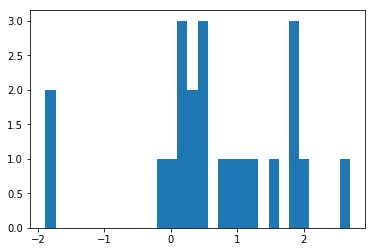

In [28]:
plt.hist(np.log(np.array(superscs_times)/np.array(scs_times)), bins=30)

(array([2., 1., 2., 1., 0., 1., 2., 0., 3., 0., 1., 0., 0., 1., 0., 2., 1.,
        1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1.]),
 array([-0.35667494, -0.28194412, -0.20721329, -0.13248247, -0.05775164,
         0.01697918,  0.09171001,  0.16644083,  0.24117166,  0.31590248,
         0.39063331,  0.46536413,  0.54009496,  0.61482578,  0.68955661,
         0.76428743,  0.83901826,  0.91374908,  0.98847991,  1.06321074,
         1.13794156,  1.21267239,  1.28740321,  1.36213404,  1.43686486,
         1.51159569,  1.58632651,  1.66105734,  1.73578816,  1.81051899,
         1.88524981]),
 <a list of 30 Patch objects>)

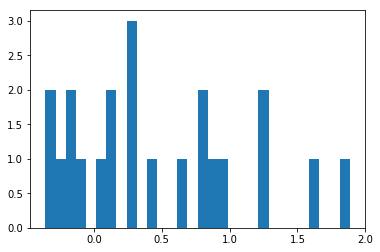

In [29]:
plt.hist(np.log(np.array(superscs_iters)/np.array(scs_iters)), bins=30)

In [30]:
stgs['use_indirect'] = False,

scs_times = []
superscs_times = []
scs_iters = []
superscs_iters = []

for prob in probs:

    print('****************************************************************************')
    print('****************************************************************************')

    # For some reason I can't get CVXPY to recognize SuperSCS is installed.
    d = prob.get_problem_data(solver='SCS')
    scs_out = scs.solve(d, d['dims'], **stgs)
    
    # SuperSCS is printing to the terminal instead of the notebook
    # cell, so this useful package captures it and I print it out.
    with pipes() as (out, err):
        superscs_out = superscs.solve(d, d['dims'], **stgs)
    print(out.read())
    
    scs_times.append(scs_out['info']['setupTime'] + scs_out['info']['solveTime'])
    scs_iters.append(float(scs_out['info']['iter']))
    superscs_times.append(superscs_out['info']['setupTime'] + superscs_out['info']['solveTime'])
    superscs_iters.append(float(superscs_out['info']['iter']))

****************************************************************************
****************************************************************************
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1500, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 100, constraints m = 170
Cones:	linear vars: 170
Setup time: 4.69e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.09e+20  1.21e+20  1.00e+00 -6.79e+20  2.79e+20  1.95e+20  7.56e-03 
   100| 5.66e-03  

---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
---------------------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 2170, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
Variables n = 310, constraints m = 470
Cones:	primal zero / dual free vars: 120
	linear vars: 200
	soc vars: 150, soc blks: 50
Setup time: 1.02e-04s
Running SuperSCS...
Memory: 352.14kB
---------------------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau |   FPR   | time (s)
---------------------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  1.77e+01  2.32e-04 
    10| 2.14e+00  1.10e+00  6.77e-01  

---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
---------------------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1402, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
Variables n = 201, constraints m = 252
Cones:	linear vars: 200
	soc vars: 52, soc blks: 1
Setup time: 6.10e-05s
Running SuperSCS...
Memory: 209.46kB
---------------------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau |   FPR   | time (s)
---------------------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  1.44e+01  1.25e-04 
    10| 3.44e-02  6.65e-02  2.07e-02  5.44e+00  5.20e+00  0.00e+00  4.69e-0

---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
---------------------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 6325, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
Variables n = 1276, constraints m = 6275
Cones:	primal zero / dual free vars: 1225
	linear vars: 2500
	sd vars: 2550, sd blks: 2
Setup time: 1.84e-04s
Running SuperSCS...
Memory: 2.95MB
---------------------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau |   FPR   | time (s)
---------------------------------------------------------------------------------------
     0| 5.12e+01  4.31e+01  9.99e-01 -3.57e+02  8.35e+02  0.00e+00  6.10e+01  1.29e-03 
    10| 8.69e-02  2.55e-02  3.11e-03  

   100| 1.74e-03  4.07e-03  5.03e-04  9.60e-01  9.58e-01  1.15e-16  2.87e+00 
   200| 7.39e-06  1.95e-05  5.36e-07  9.59e-01  9.59e-01  5.30e-17  5.14e+00 
   220| 4.03e-06  8.47e-06  2.14e-06  9.59e-01  9.59e-01  5.28e-16  5.44e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 5.44e+00s
	Lin-sys: avg # CG iterations: 8.24, avg solve time: 2.40e-02s
	Cones: avg projection time: 6.97e-06s
	Acceleration: avg step time: 3.32e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 8.7569e-15, dist(y, K*) = 3.7825e-13, s'y/|s||y| = 4.2012e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 4.0280e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 8.4713e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.1354e-06
----------------------------------------------------------------------------
c'x = 0.9594, -b'y = 0.9595
------------------------------------------------------------------

   100| 4.77e-06  1.50e-04  6.50e-06  7.49e+02  7.49e+02  5.36e-12  2.08e+00 
   120| 2.43e-07  9.15e-06  3.99e-06  7.49e+02  7.49e+02  9.01e-12  2.41e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.41e+00s
	Lin-sys: avg # CG iterations: 1.71, avg solve time: 1.84e-02s
	Cones: avg projection time: 6.81e-06s
	Acceleration: avg step time: 9.32e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 9.3402e-15, dist(y, K*) = 0.0000e+00, s'y/|s||y| = 1.0273e-06
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.4266e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 9.1534e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.9919e-06
----------------------------------------------------------------------------
c'x = 748.6264, -b'y = 748.6205
---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver
	

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 10064000, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 32000, constraints m = 72000
Cones:	linear vars: 12000
	exp vars: 60000, dual exp vars: 0
Setup time: 4.58e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.93e+21  4.84e+21  1.00e+00 -1.74e+25  3.88e+25  5.91e+24  8.12e-01 
   100| 3.52e-02  3.25e-02  1.45e-02  9.41e+02  9.69e+02  1.03e-12  4.64e+01 
   200| 3.29e-03  3.68e-03  2.55e-04  9.59e+02  9

   100| 1.92e-05  1.61e-05  3.30e-07  8.24e+02  8.24e+02  1.86e-14  1.29e+00 
   120| 1.25e-06  1.64e-06  4.05e-09  8.24e+02  8.24e+02  6.23e-15  1.50e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.50e+00s
	Lin-sys: avg # CG iterations: 3.80, avg solve time: 1.98e-03s
	Cones: avg projection time: 4.16e-03s
	Acceleration: avg step time: 4.78e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.2144e-09, dist(y, K*) = 2.0390e-08, s'y/|s||y| = -1.2361e-14
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.2493e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.6399e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.0502e-09
----------------------------------------------------------------------------
c'x = 824.1519, -b'y = 824.1519
---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver


----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1000100, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 5050, constraints m = 10100
Cones:	sd vars: 10100, sd blks: 2
Setup time: 3.46e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.14e+20  1.29e+21  9.71e-01  1.99e+21  1.36e+23  7.89e+19  1.01e-01 
   100| 5.20e-02  3.22e-02  7.58e-04  1.04e+02  1.04e+02  3.43e-15  3.60e+00 
   200| 7.42e-03  5.57e-03  8.72e-05  1.04e+02  1.04e+02  1.38e-14  7.53e+00 


   100| 2.05e-03  2.57e-04  4.14e-04 -1.57e-02 -1.53e-02  4.09e-15  5.23e-01 
   200| 2.28e-04  5.54e-06  5.64e-06 -1.53e-02 -1.53e-02  1.76e-15  9.68e-01 
   300| 4.35e-05  1.86e-06  1.77e-06 -1.53e-02 -1.53e-02  1.62e-15  1.38e+00 
   360| 8.76e-06  1.86e-06  4.42e-07 -1.53e-02 -1.53e-02  1.18e-15  1.62e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.62e+00s
	Lin-sys: avg # CG iterations: 2.74, avg solve time: 3.17e-03s
	Cones: avg projection time: 1.19e-05s
	Acceleration: avg step time: 1.01e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.0391e-12, dist(y, K*) = 1.0173e-12, s'y/|s||y| = -1.1125e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 8.7568e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.8636e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.4192e-07
----------------------------------------------------------------------------
c'x = -0.0153, 

   300| 5.69e-04  3.51e-04  4.55e-04  3.32e+01  3.32e+01  3.94e-14  2.71e-01 
   400| 9.75e-05  6.23e-05  4.22e-06  3.32e+01  3.32e+01  1.04e-14  3.54e-01 
   500| 2.93e-05  1.76e-05  3.78e-06  3.32e+01  3.32e+01  1.21e-13  4.35e-01 
   580| 8.84e-06  6.01e-06  5.76e-06  3.32e+01  3.32e+01  1.57e-13  5.02e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 5.03e-01s
	Lin-sys: avg # CG iterations: 5.66, avg solve time: 1.68e-04s
	Cones: avg projection time: 4.31e-04s
	Acceleration: avg step time: 1.61e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.3065e-09, dist(y, K*) = 1.4547e-08, s'y/|s||y| = 8.9631e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 8.8382e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.0125e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.7611e-06
----------------------------------------------------------------------------
c'x = 33.1556, -

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 10099996, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 30000, constraints m = 41000
Cones:	linear vars: 39998
	soc vars: 1002, soc blks: 1
Setup time: 4.25e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.58e+21  2.61e+21  1.00e+00 -4.58e+23  2.89e+23  2.05e+23  6.31e-01 
   100| 1.24e-03  5.86e-03  4.58e-05  1.14e+02  1.14e+02  3.08e-14  2.30e+01 
   200| 4.97e-06  2.45e-05  1.03e-07  1.14e+02  1.14e+0

   100| 8.96e-02  1.98e-01  8.01e-02  3.02e+00  3.63e+00  2.49e-15  1.84e-01 
   200| 3.96e-02  7.54e-02  6.71e-02  1.82e+00  1.53e+00  6.77e-16  3.93e-01 
   300| 4.05e-02  7.08e-02  6.56e-02  1.46e+00  1.73e+00  2.00e-15  6.09e-01 
   400| 1.58e-02  2.71e-02  2.45e-03  1.12e+00  1.11e+00  1.91e-15  8.17e-01 
   500| 7.59e-03  1.27e-02  8.52e-03  1.11e+00  1.14e+00  3.77e-16  1.02e+00 
   600| 1.07e-02  1.53e-02  3.27e-02  9.97e-01  9.02e-01  1.96e-15  1.23e+00 
   700| 7.93e-03  8.56e-03  1.61e-03  1.05e+00  1.04e+00  1.50e-16  1.44e+00 
   800| 8.75e-03  1.44e-02  1.82e-02  1.02e+00  9.64e-01  3.32e-17  1.66e+00 
   900| 1.07e-02  1.82e-02  2.08e-02  1.01e+00  9.48e-01  2.09e-15  1.87e+00 
  1000| 1.27e-02  2.07e-02  4.05e-03  1.05e+00  1.04e+00  5.87e-17  2.09e+00 
  1100| 4.41e-03  7.36e-03  7.53e-03  1.02e+00  9.93e-01  8.45e-16  2.31e+00 
  1200| 6.23e-03  9.00e-03  1.49e-02  1.00e+00  9.57e-01  1.48e-16  2.53e+00 
  1300| 4.76e-03  8.29e-03  2.13e-03  1.02e+00  1.02e+00  2.11e-

   100| 7.81e-04  9.05e-04  1.63e-04  1.80e+03  1.80e+03  5.91e-13  3.70e+00 
   200| 4.36e-05  3.92e-05  2.32e-07  1.80e+03  1.80e+03  1.66e-13  7.34e+00 
   300| 1.63e-05  1.45e-05  8.44e-07  1.80e+03  1.80e+03  1.10e-13  1.09e+01 
   320| 2.38e-06  2.43e-06  1.85e-07  1.80e+03  1.80e+03  2.66e-13  1.17e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.17e+01s
	Lin-sys: avg # CG iterations: 5.76, avg solve time: 7.58e-03s
	Cones: avg projection time: 1.26e-02s
	Acceleration: avg step time: 1.25e-02s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.1394e-08, dist(y, K*) = 1.3399e-04, s'y/|s||y| = 2.2033e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.3830e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.4288e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.8545e-07
----------------------------------------------------------------------------
c'x = 1801.4300,

---------------------------------------------------------------------------------------
	SCS v1.2.6-KUL-SuperMann - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
---------------------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 597, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
Variables n = 139, constraints m = 219
Cones:	primal zero / dual free vars: 111
	linear vars: 23
	sd vars: 70, sd blks: 2
	exp vars: 15, dual exp vars: 0
Setup time: 5.50e-05s
Running SuperSCS...
Memory: 153.34kB
---------------------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau |   FPR   | time (s)
---------------------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  7.70e+00  1.91e-04 
    10| 8.33

   100| 4.66e-03  1.41e-02  6.07e-04  9.99e+01  9.98e+01  5.98e-15  1.83e+00 
   200| 2.49e-06  1.99e-05  1.40e-07  1.00e+02  1.00e+02  3.16e-15  3.25e+00 
   240| 6.95e-07  9.48e-06  5.03e-08  1.00e+02  1.00e+02  1.62e-14  3.68e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.68e+00s
	Lin-sys: avg # CG iterations: 5.16, avg solve time: 9.21e-03s
	Cones: avg projection time: 3.45e-05s
	Acceleration: avg step time: 4.64e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 6.8684e-15, dist(y, K*) = 0.0000e+00, s'y/|s||y| = 2.1730e-14
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 6.9502e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 9.4841e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.0263e-08
----------------------------------------------------------------------------
c'x = 100.0000, -b'y = 100.0000
--------------------------------------------------------------

  3400| 8.03e-06  1.96e-05  1.69e-06  3.75e+01  3.75e+01  1.01e-13  2.85e+01 
  3500| 7.30e-06  1.77e-05  3.17e-06  3.75e+01  3.75e+01  1.18e-13  2.94e+01 
  3600| 1.05e-05  2.95e-05  8.39e-06  3.75e+01  3.75e+01  7.77e-14  3.03e+01 
  3700| 3.29e-05  8.72e-05  1.29e-05  3.75e+01  3.75e+01  1.01e-12  3.12e+01 
  3800| 5.39e-06  1.84e-05  1.15e-06  3.75e+01  3.75e+01  5.94e-14  3.21e+01 
  3840| 2.97e-06  7.54e-06  2.52e-06  3.75e+01  3.75e+01  3.08e-14  3.24e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.24e+01s
	Lin-sys: avg # CG iterations: 85.13, avg solve time: 7.91e-03s
	Cones: avg projection time: 1.02e-05s
	Acceleration: avg step time: 3.89e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.0303e-05, dist(y, K*) = 1.4173e-05, s'y/|s||y| = 2.4675e-07
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.9656e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 7.5366

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1045000, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 20200, constraints m = 30000
Cones:	primal zero / dual free vars: 5000
	linear vars: 10000
	soc vars: 15000, soc blks: 5000
Setup time: 3.57e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.46e+21  2.29e+21  1.00e+00 -1.88e+25  7.73e+23  4.01e+24  7.24e-02 
   100| 3.89e-03  5.86e-03  1.55e-03  1.49e+03  1.49e+03  1.63e-13  2.07e+00 
   200| 7.48e-04

(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 1., 2.,
        1., 1., 2., 1., 0., 1., 1., 2., 1., 0., 0., 0., 1.]),
 array([-1.94803449, -1.79361778, -1.63920108, -1.48478438, -1.33036768,
        -1.17595097, -1.02153427, -0.86711757, -0.71270086, -0.55828416,
        -0.40386746, -0.24945076, -0.09503405,  0.05938265,  0.21379935,
         0.36821605,  0.52263276,  0.67704946,  0.83146616,  0.98588287,
         1.14029957,  1.29471627,  1.44913297,  1.60354968,  1.75796638,
         1.91238308,  2.06679979,  2.22121649,  2.37563319,  2.53004989,
         2.6844666 ]),
 <a list of 30 Patch objects>)

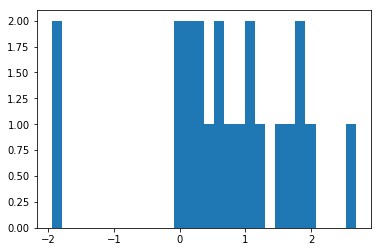

In [31]:
plt.hist(np.log(np.array(superscs_times)/np.array(scs_times)), bins=30)

(array([2., 1., 2., 1., 0., 1., 2., 0., 3., 0., 1., 0., 0., 1., 0., 2., 1.,
        1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 1.]),
 array([-0.35667494, -0.28194412, -0.20721329, -0.13248247, -0.05775164,
         0.01697918,  0.09171001,  0.16644083,  0.24117166,  0.31590248,
         0.39063331,  0.46536413,  0.54009496,  0.61482578,  0.68955661,
         0.76428743,  0.83901826,  0.91374908,  0.98847991,  1.06321074,
         1.13794156,  1.21267239,  1.28740321,  1.36213404,  1.43686486,
         1.51159569,  1.58632651,  1.66105734,  1.73578816,  1.81051899,
         1.88524981]),
 <a list of 30 Patch objects>)

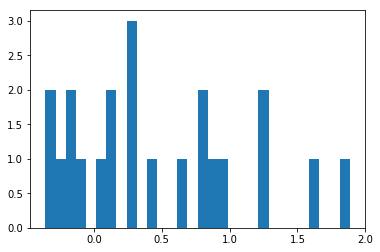

In [32]:
plt.hist(np.log(np.array(superscs_iters)/np.array(scs_iters)), bins=30)